# BBC News Classification
## An Investigation in Supervised vs Unsupervised ML Techniques

Per the __[project description](https://www.kaggle.com/competitions/learn-ai-bbc/overview/description)__, we are given 2,225 articles (or "documents" in the general context) and are tasked with predicting the category of 735 of them. The model of choice will be determined by the accuracy score. <br>
The 5 categories we will predict our articles into are:
> business <br>
tech <br>
politics <br>
sport <br>
entertainment <br>

Of the total articles, our training set contains 1,490 with a category mapped and we use this information for our supervised learning as the target variable.

While the testing set contains another 735 articles with missing a categories, we do have a sample solution dataset to calculate testing accuracy.

NOTICE: I over indexed on model options instead of EDA graphs...

In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv('bbc_news_downloaded_data/BBC News Train.csv')
test = pd.read_csv('bbc_news_downloaded_data/BBC News Test.csv')
solution_sample = pd.read_csv('bbc_news_downloaded_data/BBC News Sample Solution.csv')

### Section 1a : Data Cleaning & Preparation

In order to utilize any algorithm, we must make sure our data is of the correct type and preprocess (or clean) our text based on some logical "business" or "contextual" decisions. 

Since this is a word processessing project, we will turn these decisions into action:<br> 
1. Do we mitigate for capitization? <br> 
> Yes - We will convert to lowercase. While capital letters might add value to some parts of speach, consider Sky as a name (proper noun) vs sky as a location (regular noun), we will push all our text to lower case as to treat them equally. In other models this "simplification" might not make sense.

2. Do we mitigate for punctuation or numbers? <br> 
> Yes - We will remove these. Since we are exploring `news` articles (and not tweets or yelp reviews), punctuation like periods and commas are very common, hyphenated words could be considered as one word, parenthesis are often used as citations, and numbers can refer to currency or magnitude. These are all utilized consistently inside news articles. Because our task is to bucket the article into a category, the fact that the documents are all news articles makes them homogenous in this regard. If we were taking in documents of various types and trying to predict their specific type (say contract vs letter vs news article vs paycheck), we might make a different conclusion.

3. Do we mitigate for common words, aka "stop words"? <br>
> Yes - We will remove these. In most word processessing, these words like "so" and "the" do not add to the topic category at hand.

4. Should mutliple words be considered together? <br>
> Yes - we should set our ngrams to 2. Since many things in the world are the combination of 2 words, we will want to specify this parameter.

5. Do we consider single and plural words the same or different? <br>
> Yes - we will lemmatize our articles. In our task at hand, we care about the root word and not the specific congugation or inflection.

<br>
We will also want to tokenize our sentences into words and perform some sort of calculation to weight each word in the article. More on this as we perform the task itself.


In [2]:
import nltk
from nltk.corpus import stopwords

def filter_text(df):
    """
    This function will strip all punctuation, numbers, and stopwords from our article text.
    """
    # copy the df
    preprocess_df = df.copy()
    
    # make text lowercase, remove extra spaces, emove punctuation and numbers 
    preprocess_df['stripped_Text_0'] = preprocess_df['Text'].str.lower().replace('\s+', ' ', regex=True)\
                                .replace('[^a-zA-Z ]', '', regex=True)
    
    # make tokens
    preprocess_df['tokens'] = preprocess_df.apply(lambda row: nltk.word_tokenize(row['stripped_Text_0']), axis=1)
    
    # remove stopwords
    stop_words = stopwords.words('english')
    preprocess_df['stripped_Text'] = preprocess_df['tokens'].apply(lambda row: [' '.join(word for word in row if word not in stop_words)][0] )
    
    return preprocess_df

In [3]:
# Preprocess actions (items 1, 2, and 3)

p_train = filter_text(train)
p_test = filter_text(test)

In [56]:
# Preprocess actions (items 5)


def lemmatize_text(df):

    wnl = nltk.stem.WordNetLemmatizer()
    
    l_df = df.copy()
    
    l_df['stripped_Tokens'] = l_df.apply(lambda row: nltk.word_tokenize(row['stripped_Text']), axis=1)
    
    l_df['stripped_Tokens_pos'] = l_df.apply(lambda row: nltk.pos_tag(row['stripped_Tokens']), axis=1)
    
    l_df['noun_Text'] = l_df['stripped_Tokens_pos'].apply(lambda row: [' '.join(wnl.lemmatize(word[0],'n') for word in row if word[1]=='NN')][0] )
    
    # lemmatize each word to it's root word for all parts of speech (thus the heavy nesting)
    l_df['lemmas'] = l_df['stripped_Tokens'].apply(lambda row: [wnl.lemmatize(wnl.lemmatize(wnl.lemmatize(wnl.lemmatize(wnl.lemmatize(word,'n'),'v'),'a'),'r'),'s') for word in row] )

    # rejoin the array of words into a single string, except for the extra empty spaces
    l_df['lemma_Text'] = l_df['lemmas'].apply(lambda row: [' '.join(word for word in row)][0] )
    
    return l_df


In [57]:
l_p_train = lemmatize_text(p_train)
l_p_test = lemmatize_text(p_test)

# maybe we will want to filter our longer documents ?? 
l_p_train['lemma_word_cnt'] = l_p_train['lemma_Text'].str.len()-l_p_train['lemma_Text'].str.replace(' ','',regex=False).str.len()

#### Vectorization Explanation:

Now that we have "cleaned" our documents into only necessary root words, we can count the occurenced of each word (Countvectorizer) or calculate a weighted word percentage based on the frequency of the word inside each document and the entire document population (TF-IDF vectorizer).

In [6]:
# Preprocess actions (items 4) : 

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def calc_vect(vect,df,col):
    
    if (vect=='cv'):
        vectorizer = CountVectorizer(
                        analyzer = 'word',
                        stop_words='english',
                        ngram_range = (1,2),
                        min_df = .005, # ensures .5% of our cleaned articles contain this ngram
                        max_df = .95 # if an ngram is too frequent we will remove this as a feature
                        )
        
    else:
        vectorizer = TfidfVectorizer(
                        analyzer = 'word',
                        stop_words='english',
                        ngram_range = (1,2),
                        norm = 'l2',
                        min_df = .005, # ensures 5% of our cleaned articles contain this ngram
                        max_df = .95 # if an ngram is too frequent we will remove this as a feature
                        )
    
    train_vectors = vectorizer.fit_transform(df[col])

    try:
        len(df['Category'])>0
        col = ['ArticleId','Category']
        level = 'level_3'
    
    except:
        col = ['ArticleId']
        level = 'level_2'
    
    v_df = df[col].join(pd.DataFrame(train_vectors.todense().tolist(), columns=vectorizer.get_feature_names_out()))
    
    v_stack = v_df.reset_index().set_index(['index']+col).stack().reset_index().rename(columns={'index':'orig_index',level:'ngram',0:'article_freq'})
    v_stack = v_stack[v_stack['article_freq']!=0]
    
    v_stack['gram_cnt'] = 1+v_stack['ngram'].str.len()-v_stack['ngram'].str.replace(' ','',regex=False).str.len()
    
    return v_df.drop(columns=col),v_stack
    

In [7]:
cv_train, cv_train_stack = calc_vect('cv',l_p_train,'lemma_Text')
cv_test, cv_test_stack = calc_vect('cv',l_p_test,'lemma_Text')

### Section 1b: Exploratory Data Analysis (EDA)

Once our data is cleaned and transformed into a more usable structurebased on our logical criteria, we do some heuristics to answer questions like:
- Do we have a balance of article category representation in our data sets?
- Do certain article categories have more words than others?
- Do certain categories have more word repetition than others?
- Upon T-SNE dimensionality reduction, do we have clear groupings of article categories?

In [8]:
# Do we have an even distribution of articles in our training set?
distribution_df = cv_train_stack[cv_train_stack['gram_cnt']==1].groupby(['ArticleId','Category'])['ngram'].size().reset_index()\
    .groupby(['Category'])['ngram'].describe()[['count']]
distribution_df['pct'] = round(distribution_df['count']/sum(distribution_df['count']),2)
distribution_df

,count,pct
Category,,
business,336.0,0.23
entertainment,273.0,0.18
politics,274.0,0.18
sport,346.0,0.23
tech,261.0,0.18


From the above table, we either conclude that we have more articles for business and sports than the others. But the magnitude of the difference might not be impactful so we will move on.

<AxesSubplot:title={'center':'article_freq'}, xlabel='[Category]'>

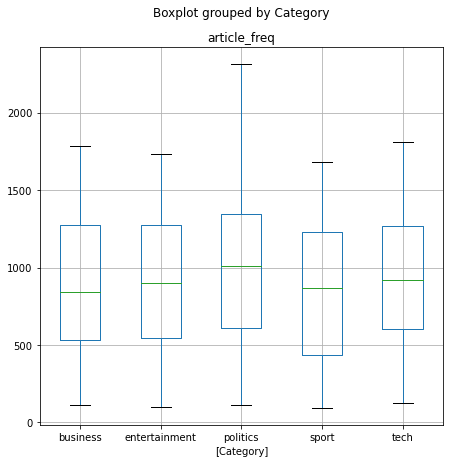

In [9]:
# how many total words are in each article category?
cv_train_stack[cv_train_stack['gram_cnt']==1].groupby(['ArticleId','Category'])['article_freq'].sum().reset_index().set_index('ArticleId')\
    .boxplot(by = ['Category'], figsize=(7,7))


array([[<AxesSubplot:title={'center':'business'}>,
        <AxesSubplot:title={'center':'entertainment'}>],
       [<AxesSubplot:title={'center':'politics'}>,
        <AxesSubplot:title={'center':'sport'}>],
       [<AxesSubplot:title={'center':'tech'}>, <AxesSubplot:>]],
      dtype=object)

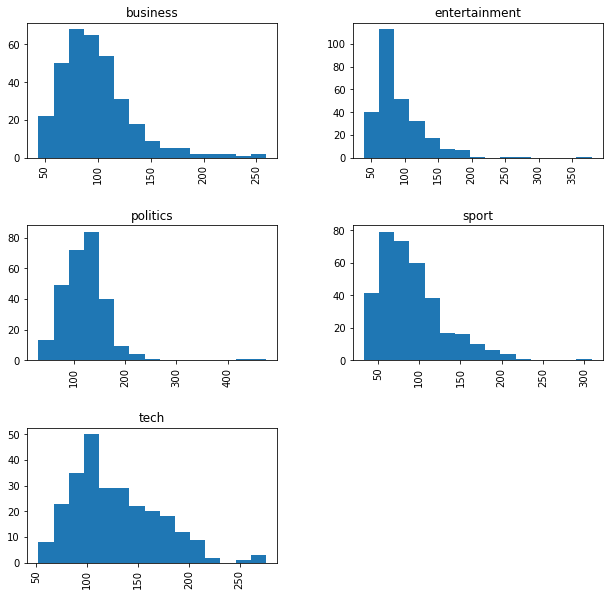

In [10]:
# how many unique words are in each article category?
cv_train_stack[cv_train_stack['gram_cnt']==1].groupby(['ArticleId','Category'])['ngram'].nunique().reset_index().set_index('ArticleId')\
    .hist(bins=15,by = ['Category'],sharex=False, figsize=(10,10))


In [11]:
# If we utilize dimensionality reduction, do we see any clear clusters?

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

colors = ["blue", "green", "darkorange",'red','black']

def scatter_viz(x,y,perp):
    X = x
    y = y
    target_names = y.drop_duplicates().values

    tsne = TSNE(n_components=2,init='pca',learning_rate='auto',random_state=20,perplexity=perp)
    X_r = tsne.fit_transform(X)

    tsne_df = pd.DataFrame(X_r,columns = ['x','y']).join(y)

    fig, ax = plt.subplots(figsize=(7,7))

    # grouped = df.groupby('continent')
    for key, color in zip(target_names,colors):
        tsne_df[tsne_df['Category']==key].plot(ax=ax, kind='scatter', x='x',y='y', label=key, color=color)

    plt.show()
    
    return

/Users/blake.tagget/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


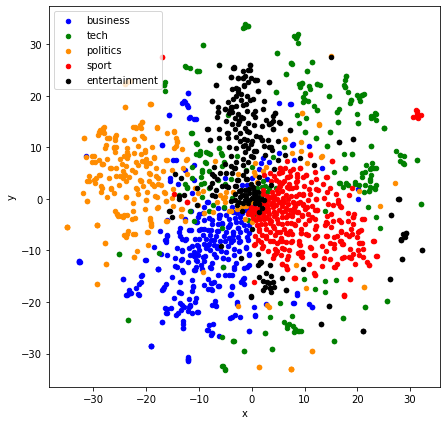

In [12]:
scatter_viz(cv_train,train['Category'],40)

When using just the counts of each ngram, we see some clostering with a lot of outliers

/Users/blake.tagget/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


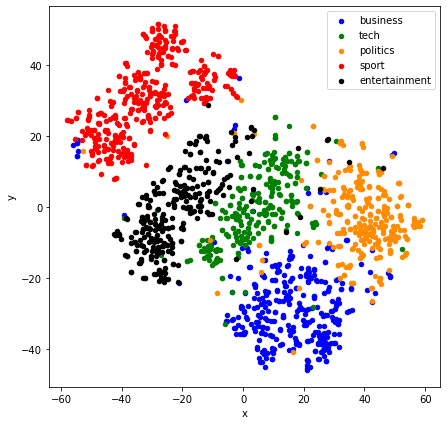

In [13]:
tfidf_train, tfidf_train_stack = calc_vect('tfidf',l_p_train,'lemma_Text')
tfidf_test, tfidf_test_stack = calc_vect('tfidf',l_p_test,'lemma_Text')
scatter_viz(tfidf_train,train['Category'],40)

When using just the percentages of each ngram in the cleaned article, we see better clustering with a some outliers.

Conclusion : When translating our ngrams into numeric values, TF-IDF produces better results than the plain frequency of each ngram. 

### Section 2 : Unsupervised Model Building and Training

Now that we have a few usable ways to clean our dataset which meet our algorithmic needs, we need to choose a model, train it with our training data and score it's accuracy. 

In [89]:
from sklearn.metrics import accuracy_score

def calc_ind(pred,df):
    indexes = list(itertools.permutations(df['Category'].drop_duplicates().values)) 

    max_score = 0
    max_ind = []

    for ind in indexes:
        ind = np.array(ind)
        pred['pred_cat'] = ind[pred['pred_col']]

        ac = accuracy_score(df['Category'], pred['pred_cat'])

        if (ac>max_score):
            max_score = ac
            max_ind = ind
            
    return max_ind, max_score

In [138]:
import itertools
from sklearn.metrics import accuracy_score
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

def unsupervised_model(train_df,test_df,col,vectorizer,nmf_model):
 
    X_train, X_test, y_train, y_test = train_test_split(train_df[[col]],train_df[['Category']], test_size=0.25, random_state=18)

    vectors = vectorizer.fit_transform(X_train[col])
    
    train_pred = pd.DataFrame(nmf_model.fit_transform(vectors.todense().tolist()))
    train_pred['pred_col'] = train_pred.idxmax(axis=1)

    train_max_ind, train_max_score = calc_ind(train_pred,y_train)
    print("Training Accuracy = ",train_max_score)
    
    test_pred = pd.DataFrame(nmf_model.transform(vectorizer.transform(X_test[col])))
    test_pred['pred_col'] = test_pred.idxmax(axis=1)
    test_pred['Category'] = train_max_ind[test_pred['pred_col']]
    print("Testing Accuracy = ", accuracy_score(test_pred['Category'], y_test['Category']))
    
    # retain the name nmf model with ALL the train data
    vectors_2 = vectorizer.fit_transform(train_df[col])
    
    train_pred = pd.DataFrame(nmf_model.fit_transform(vectors_2.todense().tolist()))
    train_pred['pred_col'] = train_pred.idxmax(axis=1)
    ind, score = calc_ind(train_pred,train_df)
    print("Official Training Accuracy = ",score)
    
    # predict the official test data
    test_pred = pd.DataFrame(nmf_model.transform(vectorizer.transform(test_df[col])))
    test_pred['pred_col'] = test_pred.idxmax(axis=1)
    test_df['Category'] = ind[test_pred['pred_col']]
    
    return vectorizer, nmf_model, train_max_ind, train_max_score, test_df[['ArticleId','Category']]

#### Batch 1
I have run this model dozens of times. Below you can see some of the combinations of parameters in the TF-IDF vectorizer and NMF model I played with.

In [ ]:
t2 = unsupervised_model(l_p_train,l_p_test,'Text',
                         TfidfVectorizer(ngram_range=(1,2)),
                         NMF(n_components=5,init='nndsvda',solver='mu',beta_loss='kullback-leibler',random_state=0)
                        )

Results
Training Accuracy =  0.7833482542524619
Testing Accuracy =  0.903485254691689
Official Training Accuracy =  0.7308724832214765
Kaggle Score = 0.78639

In [ ]:
t50 = unsupervised_model(l_p_train,l_p_test,'Text',
                         TfidfVectorizer(ngram_range=(1,2),min_df=.005),
                         NMF(n_components=5,init='nndsvda',solver='mu',beta_loss='kullback-leibler',random_state=0)
                        )
Results
Training Accuracy =  0.9471799462846912
Testing Accuracy =  0.9651474530831099
Official Training Accuracy =  0.9523489932885906
Kaggle Score = 0.96326

In [ ]:
s50 = unsupervised_model(l_p_train,l_p_test,'stripped_Text',
                         TfidfVectorizer(ngram_range=(1,2),min_df=.005),
                         NMF(n_components=5,init='nndsvda',solver='mu',beta_loss='kullback-leibler',random_state=0)
                        )
Results
Training Accuracy =  0.9579230080572964
Testing Accuracy =  0.9597855227882037
Official Training Accuracy =  0.959731543624161
Kaggle Score = 0.95374

In [ ]:
s25 = unsupervised_model(l_p_train,l_p_test,'stripped_Text',
                         TfidfVectorizer(ngram_range=(1,2),min_df=.0025),
                         NMF(n_components=5,init='nndsvda',solver='mu',beta_loss='kullback-leibler',random_state=0)
                        )

Results
Training Accuracy =  0.9623992837958818
Testing Accuracy =  0.9571045576407506
Official Training Accuracy =  0.963758389261745
Kaggle Score = 0.96326

In [ ]:
f50 = unsupervised_model(l_p_train,l_p_test,'lemma_Text',
                         TfidfVectorizer(ngram_range=(1,2),min_df=.005),
                         NMF(n_components=5,init='nndsvda',solver='mu',beta_loss='kullback-leibler',random_state=0)
                        )

Results
Training Accuracy =  0.936436884512086
Testing Accuracy =  0.938337801608579
Official Training Accuracy =  0.9570469798657718
Kaggle Score = 0.95374

In [ ]:
f25 = unsupervised_model(l_p_train,l_p_test,'lemma_Text',
                         TfidfVectorizer(ngram_range=(1,2),min_df=.0025),
                         NMF(n_components=5,init='nndsvda',solver='mu',beta_loss='kullback-leibler',random_state=0)
                        )
Results
Training Accuracy =  0.9516562220232766
Testing Accuracy =  0.9571045576407506
Official Training Accuracy =  0.9630872483221476
Kaggle Score = 0.96734

#### Conclusion 1 : 
In the above modeling runs, we got the highest testing scores when we use most of the text in our vectors. This suggests that the nuance in the verbiage allows for more specific predictions but including all of it will add too much noise. We can see that for NMF models, there is little difference between these combinations. I'd likely take the last model as a baseline to use in future projects and moving forward in this project for comparisons.

It's also important to note that t2 took a while to run. Not removing all the rarely used words AND creating unigrams and bigrams in our vectors consumed a lot of resources.

#### Batch 2

In [ ]:
c1 = unsupervised_model(l_p_train,l_p_test,'stripped_Text',
                         TfidfVectorizer(ngram_range=(1,2),min_df=.01),
                         NMF(n_components=5,init='nndsvda',solver='mu',beta_loss='kullback-leibler',random_state=0)
                        )

Results
Training Accuracy =  0.954341987466428
Testing Accuracy =  0.9705093833780161
Official Training Accuracy =  0.9557046979865772
Kaggle Score = 0.95918

In [ ]:
c2 = unsupervised_model(l_p_train,l_p_test,'stripped_Text',
                         TfidfVectorizer(ngram_range=(1,1),min_df=.01,max_df=.95),
                         NMF(n_components=5,init='nndsvda',solver='mu',beta_loss='kullback-leibler',random_state=0)
                        )

Results
Training Accuracy =  0.9516562220232766
Testing Accuracy =  0.9597855227882037
Official Training Accuracy =  0.9362416107382551
Kaggle Score = 0.93061

In [ ]:
c3 = unsupervised_model(l_p_train,l_p_test,'stripped_Text',
                         TfidfVectorizer(ngram_range=(1,1),min_df=.01,max_df=.95),
                         NMF(n_components=5,init='nndsvda',random_state=0)
                        )

Results
Training Accuracy =  0.9042076991942704
Testing Accuracy =  0.9088471849865952
Official Training Accuracy =  0.9033557046979865
Kaggle Score = 0.89931

In [ ]:
c4 = unsupervised_model(l_p_train,l_p_test,'stripped_Text',
                         TfidfVectorizer(ngram_range=(1,1),min_df=.01,max_df=.95),
                         NMF(n_components=5,init='random',random_state=0)
                        )

Results
Training Accuracy =  0.900626678603402
Testing Accuracy =  0.8981233243967829
Official Training Accuracy =  0.9221476510067114
Kaggle Score = 0.93469

In [ ]:
c5 = unsupervised_model(l_p_train[l_p_train['lemma_word_cnt']<=600],l_p_test,'lemma_Text',
                         TfidfVectorizer(ngram_range=(1,2),min_df=.1,max_df=.9, max_features=400),
                         NMF(n_components=5,init='random',solver='mu',beta_loss='kullback-leibler',random_state=0)
                        )


Results
Training Accuracy =  0.8394950405770965
Testing Accuracy =  0.8216216216216217
Official Training Accuracy =  0.8309668695064233
Kaggle Score = 0.81904

#### Conclusion 2 :
After dropping the training score as the priority, we see a drop in final score as well. These subsequent model tweaks did nothing to improve our results (but they did run faster that the prior batch).

#### Batch 3 (not using NMF)

Let's use a KMeans model and see how it compares to NMF. We will try to use the same TF-IDF as our favored f25 model from Batch 1, but due to model changes might have to make some adjustments.

In [154]:

vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=.0025)

train_vectors = pd.DataFrame(vectorizer.fit_transform(l_p_train['lemma_Text']).todense().tolist(), columns=vectorizer.get_feature_names_out())
test_vectors = pd.DataFrame(vectorizer.transform(l_p_test['lemma_Text']).todense().tolist(), columns=vectorizer.get_feature_names_out())

# KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(train_vectors)

train_pred = pd.DataFrame(kmeans.predict(train_vectors)).rename(columns={0:'pred_col'})
train_max_ind, train_max_score = calc_ind(train_pred,l_p_train)
print("Training Accuracy = ",train_max_score)

test_pred = pd.DataFrame(kmeans.predict(test_vectors)).rename(columns={0:'pred_col'})
test_pred['Category'] = train_max_ind[test_pred['pred_col']]

answer = test.join(test_pred)[['ArticleId','Category']]

## Kaggle Score = 0.91428

Training Accuracy =  0.9140939597315436


We can see that the KMeans model did a pretty okay job in that the training and the testing scores are really close and it's worse than our better NMF models.

Moving forward, we will use our best kaggle score for comparison = 96.73%

In [177]:
sts = {
    't2' : [0.7308724832214765,0.78639],
    't50' : [0.9523489932885906,0.96326],
    's50' : [0.959731543624161,0.95374],
    's25' : [0.963758389261745,0.96326],
    'f50' : [0.9570469798657718,0.95374],
    'f25' : [0.9630872483221476,0.96734],
    'c1' : [0.9557046979865772,0.95918],
    'c2' : [0.9362416107382551,0.93061],
    'c3' : [0.9033557046979865,0.89931],
    'c4' : [0.9221476510067114,0.93469],
    'c5' : [0.8309668695064233,0.81904],
    'kmeans': [0.9140939597315436,0.91428]
      }

results_summary = pd.DataFrame(sts).T
results_summary.columns=['Training_Score','Kaggle_Score']

results_summary.sort_values(by='Kaggle_Score',ascending=False)

,Training_Score,Kaggle_Score
f25,0.963087,0.96734
t50,0.952349,0.96326
s25,0.963758,0.96326
c1,0.955705,0.95918
s50,0.959732,0.95374
f50,0.957047,0.95374
c4,0.922148,0.93469
c2,0.936242,0.93061
kmeans,0.914094,0.91428
c3,0.903356,0.89931


## Addressing questions from the assignment: 
1) When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?
- No. Never include testing data when deciding on the model. What I have done here is split the training data into training and test to make iteration faster (as to not constantly upload to kaggle - even though I did to close the confidence loop). Once I have a model I like, I "retrain" the model using the complete training set, make the predictions from the test set, and submit. This worked well.


2) Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.
- Done (many times!)


3) Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle. 
- Done (many times!)


4) Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.
- Per the above table, we can see that we need to strike a balance between using every word (worst score) and using most words / lemmas.


5) Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc. 
- Done (many times!)


### Section 3 : Supervised Model Comparison

Now let's take our cleaned text and predict the categories using some supervised learning methods. I'll tweak / tune behind the scenes again and save you the tedious outputs. For even comparison, let's use the same TF-IDF translation from f25 way above.

Fun Fact : I should probably have been using sklearn pipelines for this - maybe for the next assignment!

In [157]:
X_train = train_vectors.copy()
X_test = test_vectors.copy()
y_train = l_p_train['Category']

In [158]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)

print("Training Accuracy = ",lr.score(X_train, y_train))
results = test.join(pd.DataFrame({'Category':lr.predict(X_test)}))[['ArticleId','Category']]


## Kaggle Score = 0.97959

Training Accuracy =  0.9973154362416108


In [160]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)

print("Training Accuracy = ",neigh.score(X_train, y_train))
results = test.join(pd.DataFrame({'Category':neigh.predict(X_test)}))[['ArticleId','Category']]

## Kaggle Score = 0.94965

Training Accuracy =  0.9630872483221476


In [162]:
# Linear Support Vector Classification 

# multi_class{‘ovr’, ‘crammer_singer’}

from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train, y_train)

print("Training Accuracy = ",clf.score(X_train, y_train))
results = test.join(pd.DataFrame({'Category':clf.predict(X_test)}))[['ArticleId','Category']]

## Kaggle Score = 0.98231

Training Accuracy =  1.0


In [164]:
# C-Support Vector Classification 

from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

print("Training Accuracy = ",clf.score(X_train, y_train))

results = test.join(pd.DataFrame({'Category':clf.predict(X_test)}))[['ArticleId','Category']]

## Kaggle Score = 0.98367

Training Accuracy =  1.0


### Section 4 : Summary and Review

Wow. Look at all those models. this was a fun assignment to take my time with and learn that there are economies of scale with respect to model tuning and that choosing a different model in general can really boost the score. Oddly enough, per the results above, I don't think I overfit any of my models (i.e. there are now high training score and low testing score combinations). If I were to do this again I'd write a function to loop though different models / parameters in an automated fashion, produce a results table and move on. this would save a lot of timewaiting for the program to finish.

#### References
As stated in the assignment directions, using other information on the internet and other Kaggle code sumbissions is allowed to help us learn.

The following is a list of web pages I consulted when creating this assignment:

https://www.analyticsvidhya.com/blog/2021/06/part-15-step-by-step-guide-to-master-nlp-topic-modelling-using-nmf/
https://monkeylearn.com/blog/what-is-tf-idf/
https://datascience-george.medium.com/using-tf-idf-for-document-classification-d75794e3d321
https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classificationhttps://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification

Influencial code examples: 
https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization


